In [205]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import io
import time
import subprocess
import sys
import os

In [2]:
# Modify the IDF file

%run "../..//PythonScripts/00_ModifyIDF_FullConstructions.py" "Test_4Zone.idf" "../../Resources/idf_config.json" "testestest.idf"
# %run "../..//PythonScripts/00_ModifyIDF_FullConstructions.py" "Test_4Zone.idf" "../../Resources/idf_config_os.json"


Config loaded from ../../Resources/idf_config.json

IDF loaded from Test_4Zone.idf

EPW loaded from C:/Users/tgerrish/Desktop/SAMAzure/TestFiles/Resources/GBR_Cardiff_CIBSE_TRY_CONVERTED.epw

Zone conditions loaded from C:/Users/tgerrish/Desktop/SAMAzure/TestFiles/Resources/internal_gains_library.json
Zone conditions set to High Density Seminar Room

SITE:LOCATION modified
VERSION modified
SIZINGPERIOD:DESIGNDAY modified
SIMULATIONCONTROL modified
RUNPERIOD modified
SITE:GROUNDTEMPERATURE:BUILDINGSURFACE modified
BUILDING modified
TIMESTEP modified
SHADOWCALCULATION modified
SCHEDULETYPELIMITS modified
SCHEDULE:DAY:INTERVAL modified
SCHEDULE:DAY:HOURLY modified
SCHEDULE:WEEK:DAILY modified
SCHEDULE:WEEK:COMPACT modified
SCHEDULE:YEAR modified
PEOPLE modified
LIGHTS modified
ELECTRICEQUIPMENT modified
ZONEINFILTRATION:DESIGNFLOWRATE modified
ZONEVENTILATION:DESIGNFLOWRATE modified
HVACTEMPLATE:THERMOSTAT modified
HVACTEMPLATE:ZONE:IDEALLOADSAIRSYSTEM modified
DESIGNSPECIFICATION:OUTDOO

In [377]:
######################
# Run the Eplus file #
######################

# Delete the files we dont need

old_results = [
    "eplusmtr.csv",
    "eplusout.audit",
    "eplusout.bnd",
    "eplusout.csv",
    "eplusout.eio",
    "eplusout.end",
    "eplusout.err",
    "eplusout.eso",
    "eplusout.expidf",
    "eplusout.mdd",
    "eplusout.mtd",
    "eplusout.rdd",
    "eplusout.rvaudit",
    "eplusout.shd",
    "eplusout.sql",
    "sqlite.err",
    "test.log",
]

for _file in old_results:
    try:
        os.remove(_file)
#         print("{0:} removed".format(_file))
    except:
        pass
#         print("{0:} not found".format(_file))

print("\nRunning simulation ...")

weatherfile = "C:/Users/tgerrish/Desktop/SAMAzure/TestFiles/Resources/GBR_Cardiff_CIBSE_TRY_ORIGINAL.epw"
subprocess.call("C:/EnergyPlusV8-8-0/energyplus.exe -a -x -r -w {0:} C:/Users/tgerrish/Desktop/SAMAzure/TestFiles/reference/outputComparison/Test_4Zone_modified.idf".format(weatherfile), shell=True)
# weatherfile = "/Users/Tristan/Desktop/SAMAzure/TestFiles/Resources/GBR_Cardiff_CIBSE_TRY_ORIGINAL.epw"
# subprocess.call("/Applications/EnergyPlus-8-8-0/energyplus-8.8.0 -a -x -r -w /Users/Tristan/Desktop/SAMAzure/TestFiles/Resources/GBR_Cardiff_CIBSE_TRY_ORIGINAL.epw /Users/Tristan/Desktop/SAMAzure/TestFiles/reference/outputComparison/Test_4Zone_modified.idf", shell=True)

print("Simulation complete")

# filename = 'test.log'
# with io.open(filename, 'wb') as writer, io.open(filename, 'rb', 1) as reader:
#     try:
#         process = subprocess.Popen("C:/EnergyPlusV8-8-0/energyplus.exe -a -x -r -w C:/Users/tgerrish/Desktop/SAMAzure/TestFiles/Resources/GBR_Cardiff_CIBSE_TRY.epw C:/Users/tgerrish/Desktop/temp_delete/Test_4Zone_modified.idf", stdout=writer)
#     except:
#         process = subprocess.Popen("/Applications/EnergyPlus-8-8-0/energyplus -a -x -r -w /Users/Tristan/Desktop/SAMAzure/TestFiles/Resources/GBR_Cardiff_CIBSE_TRY.epw /Users/Tristan/Desktop/SAMAzure/TestFiles/reference/outputComparison/Test_4Zone_modified.idf", stdout=writer)
#     while process.poll() is None:
#         sys.stdout.write(reader.read())
#         time.sleep(0.5)
#     # Read the remaining
#     sys.stdout.write(reader.read())


Running simulation ...
Simulation complete


In [378]:
##################################################
# LOAD THE WEATHER FILE USED TO RUN THE IDF FILE #
##################################################

def load_weather_epw_alt(path, start_day="Monday"):
    year = {
            "Monday": "2018",
            "Tuesday": "2002",
            "Wednesday": "2003",
            "Thursday": "2009",
            "Friday": "2010",
            "Saturday": "2011",
            "Sunday": "2006"
        }[start_day]

    loc_dict = {
        6: 'dry_bulb_temperature',
        7: 'dew_point_temeperature',
        8: 'relative_humidity',
        9: 'atmospheric_station_pressure',
        10: 'extraterrestrial_horizontal_radiation',
        11: 'extraterrestrial_direct_normal_radiation',
        12: 'horizontal_infrared_radiation_intensity',
        13: 'global_horizontal_radiation',
        14: 'direct_normal_radiation',
        15: 'diffuse_horizontal_radiation',
        16: 'global_horizontal_illuminance',
        17: 'direct_normal_illuminance',
        18: 'diffuse_horizontal_illuminance',
        19: 'zenith_luminance',
        20: 'wind_direction',
        21: 'wind_speed',
        22: 'total_sky_cover',
        23: 'opaque_sky_cover',
        24: 'visibility',
        25: 'ceiling_height',
        26: 'present_weather_observation',
        27: 'present_weather_codes',
        28: 'precipitable_water',
        29: 'aerosol_optical_depth',
        30: 'snow_depth',
        31: 'days_since_last_snowfall',
        32: 'albedo',
        33: 'liquid_precipitation_depth',
        34: 'liquid_precipitation_quantity'
    }

    with open(path) as f:
        content = f.readlines()
        content = [i.split(",") for i in [x.strip() for x in content]]

    df = pd.DataFrame(data=content[-8760:])
    df.replace(-999, 0, inplace=True)
    df.set_index(pd.date_range(start=year+"-01-01 00:00", end=year+"-12-31 23:00", freq="60T"), inplace=True)
    df.rename(loc_dict, axis=1, inplace=True)
    df = df[loc_dict.values()]
    df = df.astype("float64", errors="ignore")

    df["city"] = content[0][1].strip()
    df["country"] = np.nan
    df["latitude"] = float(content[0][-3].strip())
    df["longitude"] = float(content[0][-2].strip())
    df["elevation"] = float(content[0][-1].strip())
    df["filename"] = os.path.basename(path).replace(".csv", "")

    return df

EPLUS_WEATHER = load_weather_epw_alt(weatherfile)

In [385]:
################################
# Load IES performance results #
################################

IES_OUTPUT = "Test_4ZoneIES/vista/File Name [IESCheck.aps].csv"

IES = pd.read_csv(IES_OUTPUT, index_col=[0, 1, 2, 3], header=[0, 1, 2], error_bad_lines=False, warn_bad_lines=False).transpose().iloc[:-1, :]

# TIDY IES RESULTS FILE
IES.index = pd.DatetimeIndex(start="2018-01-01 00:30", end="2018-12-31 23:30", freq="60T")
IES.columns = pd.MultiIndex.from_tuples(list(zip(*[IES.columns.get_level_values(3), IES.columns.get_level_values(0)])), names=["zone", "variable"])
IES.sort_index(axis=1, ascending=True, inplace=True)
IES = IES.apply(pd.to_numeric, errors="coerce")

############################
# Load IES weather results #
############################

IES_WEATHER_PATH = "Test_4ZoneIES/vista/Chart(1).txt"

IES_WEATHER = pd.read_csv(IES_WEATHER_PATH, sep=r'\t', engine='python')

with open(IES_WEATHER_PATH, "r") as f:
    a = [i.replace("Mon,", "Mon").replace("Tue,", "Tue").replace("Wed,", "Wed").replace("Thu,", "Thu").replace("Fri,", "Fri").replace("Sat,", "Sat").replace("Sun,", "Sun").replace("\t", ", ").strip() for i in f.readlines()]
    
    # Get the number of variables in the file
    num_vars = len(a[0].split(", "))
    
    # Get the header values
    header = [i.replace("Global radiation (W/m\xb2)", "global_horizontal_radiation").replace("Wet-bulb temperature (\xb0C)", "wet_bulb_temperature").replace("Dry-bulb temperature (\xb0C)", "dry_bulb_temperature").replace("External relative humidity (%)", "relative_humidity") for i in a[0].split(", ")[2:]]
    
    # Get the values
    ll = []
    for row in a[4:]:
        if len(row.split(", ")) == num_vars:
            ll.append(row.split(", ")[2:])
        elif len(row.split(", ")) == num_vars - 1:
            ll.append([i.replace(",", "") for i in row.split(", ")[2:]] + [np.nan])
    
IES_WEATHER = pd.DataFrame(data=ll, columns=header, index=pd.DatetimeIndex(start="2018-01-01 00:30", end="2018-12-31 23:30", freq="30T"))
IES_WEATHER.fillna(value=np.nan, inplace=True)

def convert_fill(df):
    return df.stack().apply(pd.to_numeric, errors='ignore').fillna(np.nan).unstack()

IES_WEATHER = convert_fill(IES_WEATHER)
IES_WEATHER = IES_WEATHER.resample("60T").mean()

#######################################
# Load energyplus performance results #
#######################################

EPLUS_OUTPUT = "eplusout.csv"
EPLUS = pd.read_csv(EPLUS_OUTPUT, index_col=0, header=0, low_memory=False)
EPLUS.index = pd.DatetimeIndex(start="2018-01-01 01:00", end="2019-01-01 00:00", freq="60T")
for col in EPLUS.columns:
    if "[J]" in col:
        EPLUS[col] = EPLUS[col] / 3600000
#         EPLUS.rename(columns={EPLUS[col].name:EPLUS[col].name.replace("[J]", "[kW]")}, inplace=True)
    elif "[m3]" in col or "[m3/s]" in col:
        EPLUS[col] = EPLUS[col] * 1000
#         EPLUS.rename(columns={EPLUS[col].name:EPLUS[col].name.replace("[m3]", "[l]")}, inplace=True)
#         EPLUS.rename(columns={EPLUS[col].name:EPLUS[col].name.replace("[m3/s]", "[l/s]")}, inplace=True)

link_vars = {
    "Zone Electric Equipment Total Heating Energy [J](Hourly)": "Equipment gain",
    "Zone Lights Total Heating Energy [J](Hourly)": "Lighting gain",
    "Zone People Total Heating Energy [J](Hourly)": "People gain",
    "Zone Air Relative Humidity [%](Hourly)": "Relative humidity",
    "Zone Air Temperature [C](Hourly)": "Air temperature",
    "Zone Mean Radiant Temperature [C](Hourly)": "Mean radiant temperature",
    "Zone Thermostat Cooling Setpoint Temperature [C](Hourly)": "Cooling set point",
    "Zone Thermostat Heating Setpoint Temperature [C](Hourly)": "Heating set point",
    "Zone Mechanical Ventilation Current Density Volume Flow Rate [m3/s](Hourly)": "Natural vent",
    "Zone Windows Total Transmitted Solar Radiation Energy [J](Hourly)": "Solar gain",
    "Zone People Occupant Count [](Hourly)": "Number of people",
    "Zone Total Internal Total Heating Energy [J](Hourly)": "Internal gain",
    "Zone Mean Air Dewpoint Temperature [C](Hourly)": "Dew-point temperature",
    "Zone Ideal Loads Outdoor Air Sensible Heating Energy [J](Hourly)": "Heating plant sensible load",
    "Zone Ideal Loads Outdoor Air Sensible Cooling Energy [J](Hourly)": "Cooling plant sensible load",
}

zoneName = []
zoneVariable = []
for i, j in [k.split(":") for k in EPLUS.columns]:
    zoneName.append(i.replace(" IDEAL LOADS AIR SYSTEM", "").title())
    zoneVariable.append(link_vars[j.strip()])

EPLUS.columns = pd.MultiIndex.from_tuples(list(zip(*[zoneName, zoneVariable])), names=["zone", "variable"])
EPLUS.sort_index(axis=1, ascending=True, inplace=True)
EPLUS = EPLUS.astype(dtype="float64", errors="ignore")

########################################
# Load energyplus construction results #
########################################
def get_eplus_construction_properties(path):
    with open(path, "r") as f:
        m = f.readlines()
        for n, i in enumerate(m):
            if "Construction CTF" in i:
                const_n = n
            if "Material CTF Summary" in i:
                constmat_n = n
            if "WindowConstruction" in i:
                win_n = n
            if "WindowMaterial:Glazing" in i:
                winmat_n = n

    cf1 = pd.DataFrame([i.rstrip().split(",") for i in m[const_n+2:constmat_n-2]]).iloc[:, 1:]
    cf1 = cf1.rename(columns=cf1.iloc[0]).drop(cf1.index[0])#[["Construction", "Reflectance", "U-Factor with Film [W/m2-K]", "U-Factor no Film [W/m2-K]"]]
    cf1.set_index("Construction Name", drop=True, inplace=True)
    cf1 = cf1[["ThermalConductance {w/m2-K}", "OuterThermalAbsorptance", "InnerThermalAbsorptance", "OuterSolarAbsorptance", "InnerSolarAbsorptance"]]
    cf1.columns = ["U-Value W/m2K", "Outer Thermal Absorptance", "Inner Thermal Absorptance", "Outer Solar Absorptance", "Inner Solar Absorptance"]

    cf2 = pd.DataFrame([i.rstrip().split(",") for i in m[win_n+2:winmat_n-2]]).iloc[:, 1:]
    cf2 = cf2.rename(columns=cf2.iloc[0]).drop(cf2.index[0])
    cf2.set_index("Construction Name", drop=True, inplace=True)
    cf2 = cf2[["Conductance {W/m2-K}", "SHGC", "Solar Transmittance at Normal Incidence", "Visible Transmittance at Normal Incidence"]]
    cf2.columns = ["U-Value W/m2K", "SHGC", "Solar Transmittance", "Visible Transmittance"]

    return pd.concat([cf1, cf2], sort=True)

CONSTRUCTIONS = get_eplus_construction_properties("eplustbl.csv")

# THIS PRINTS THE CONSTRUCTIONS!!!!!!!
CONSTRUCTIONS

Inner Solar Absorptance Inner Thermal Absorptance  \
Construction Name                                                     
INTERIOR WALL                       0.400                     0.100   
EXTERIOR WALL                       0.400                     0.100   
INTERIOR FLOOR                      0.500                     0.900   
EXTERIOR FLOOR                      0.700                     0.900   
INTERIOR CEILING                    0.300                     0.900   
EXTERIOR ROOF                       0.300                     0.900   
AIR WALL                            0.001                     0.001   
EXTERIOR WINDOW                       NaN                       NaN   
INTERIOR WINDOW                       NaN                       NaN   

                  Outer Solar Absorptance Outer Thermal Absorptance   SHGC  \
Construction Name                                                            
INTERIOR WALL                       0.400                     0.100    NaN   
EXTERIOR WALL                       0.700                     0.100    NaN   
INTERIOR FLOOR                      0.300                     0.900    NaN   
EXTERIOR FLOOR                      0.700                     0.900    NaN   
INTERIOR CEILING                    0.500                     0.900    NaN   
EXTERIOR ROOF                       0.500                     0.900    NaN   
AIR WALL                            0.001                     0.001    NaN   
EXTERIOR WINDOW                       NaN                       NaN  0.599   
INTERIOR WINDOW                       NaN                       NaN  0.950   

                  Solar Transmittance U-Value W/m2K Visible Transmittance  
Construction Name                                                          
INTERIOR WALL                     NaN        0.5000                   NaN  
EXTERIOR WALL                     NaN        0.2199                   NaN  
INTERIOR FLOOR                    NaN         1.000                   NaN  
EXTERIOR FLOOR                    NaN        0.2199                   NaN  
INTERIOR CEILING                  NaN         1.000                   NaN  
EXTERIOR ROOF                     NaN        0.1797                   NaN  
AIR WALL                          NaN         13.10                   NaN  
EXTERIOR WINDOW                 0.525         1.600                 0.651  
INTERIOR WINDOW                 0.934         5.787                 0.901

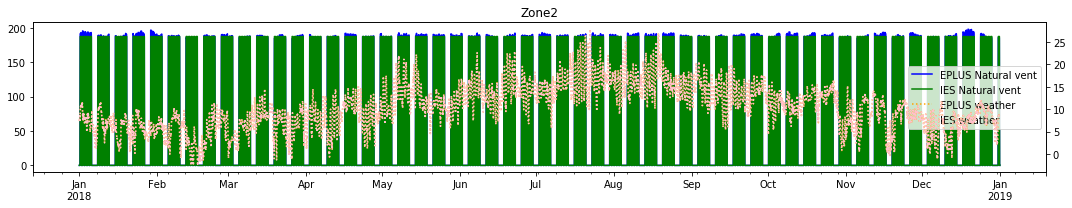

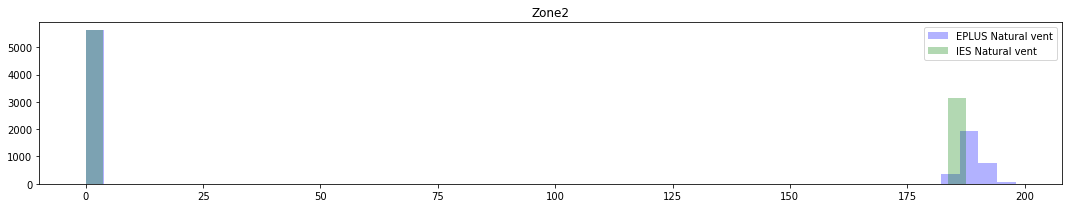

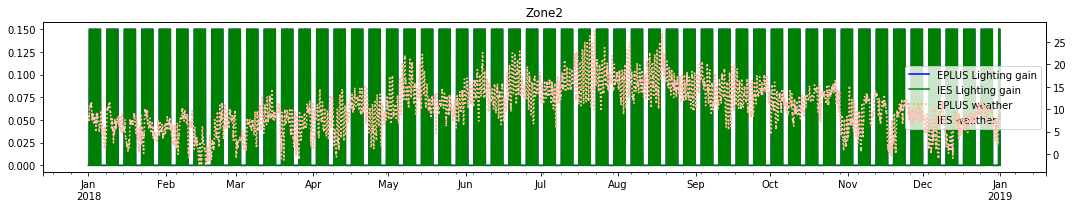

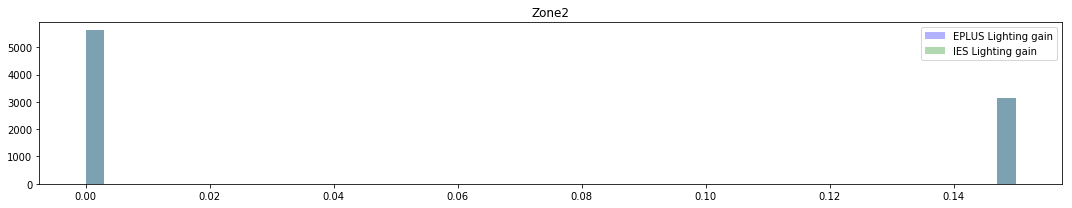

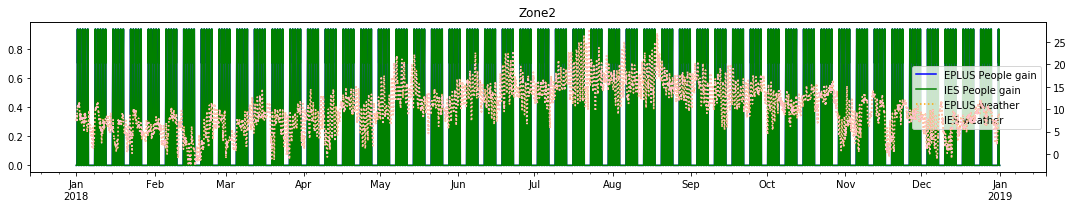

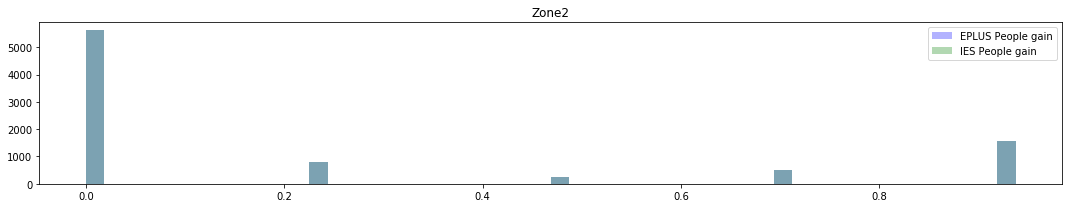

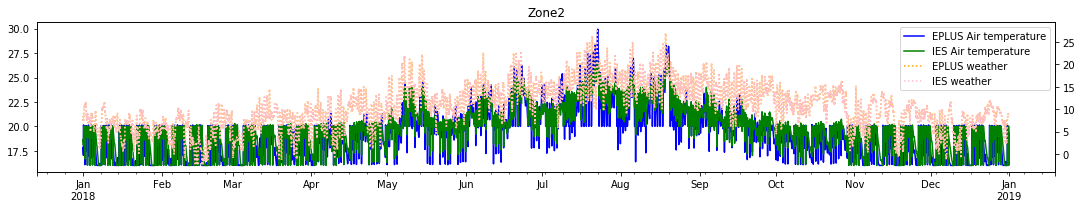

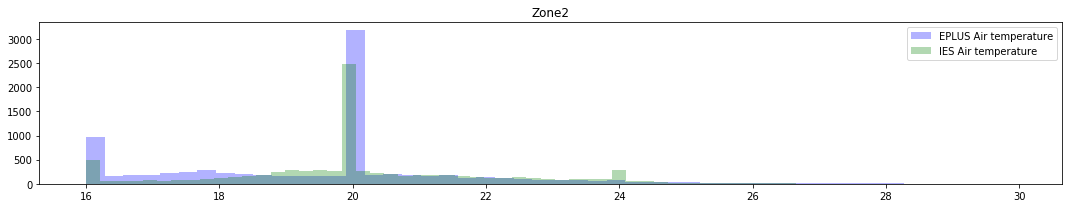

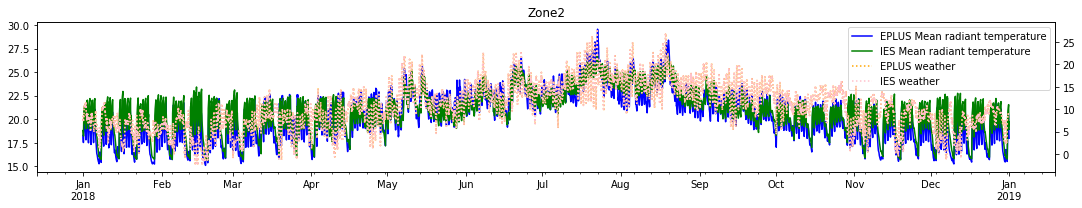

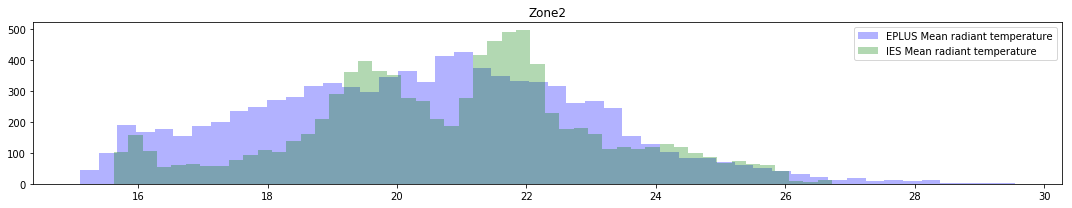

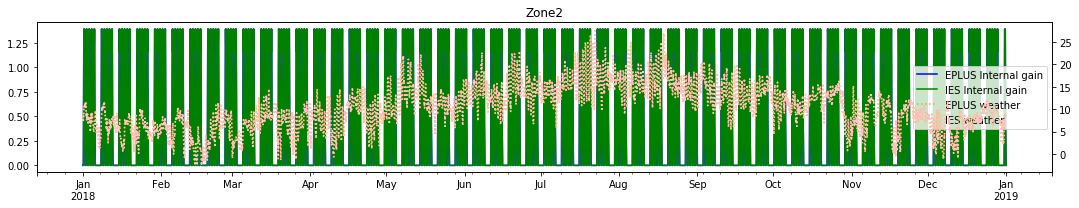

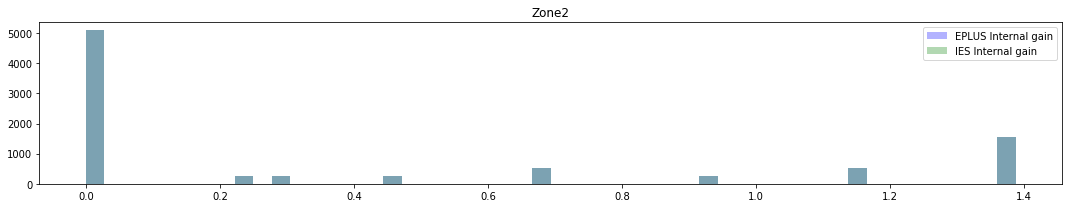

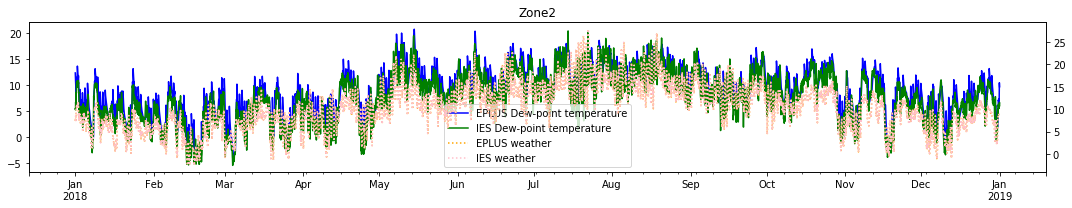

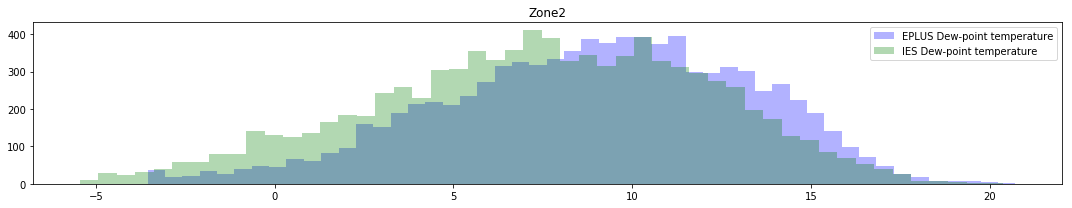

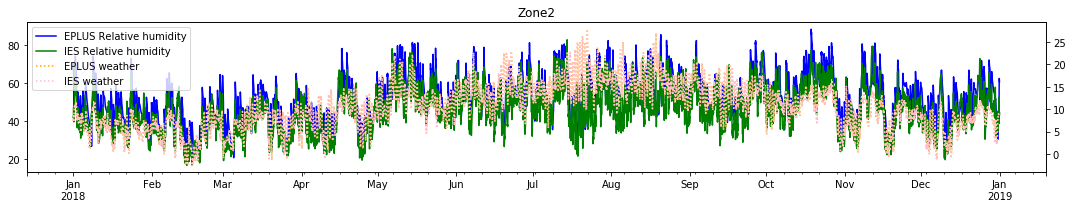

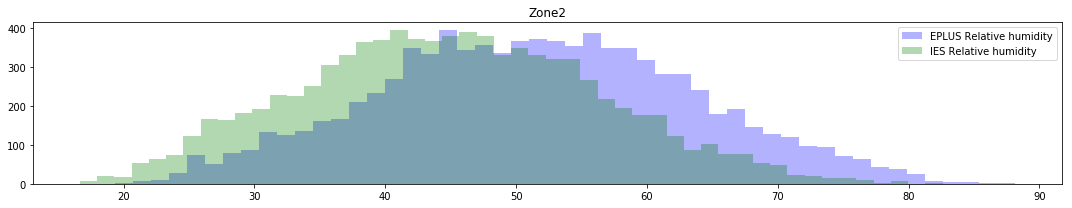

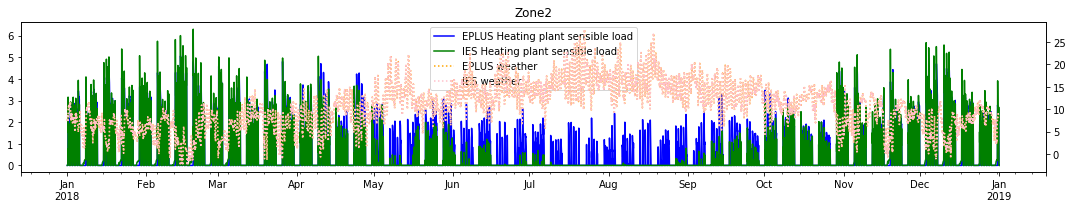

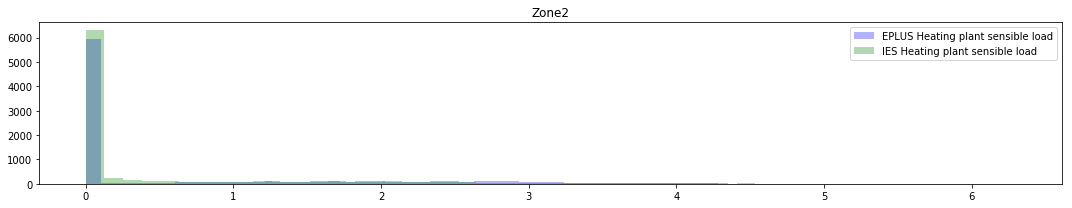

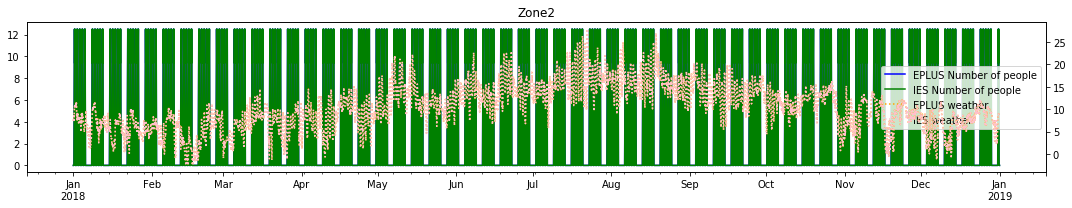

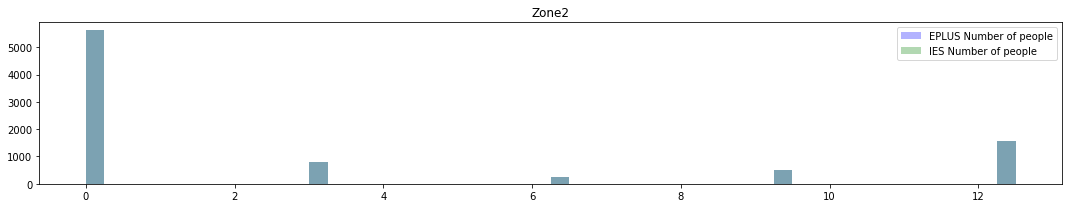

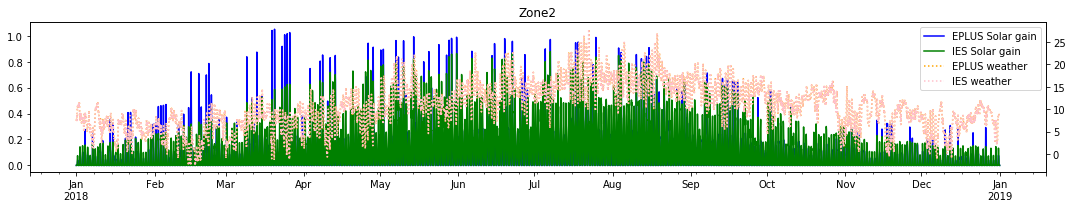

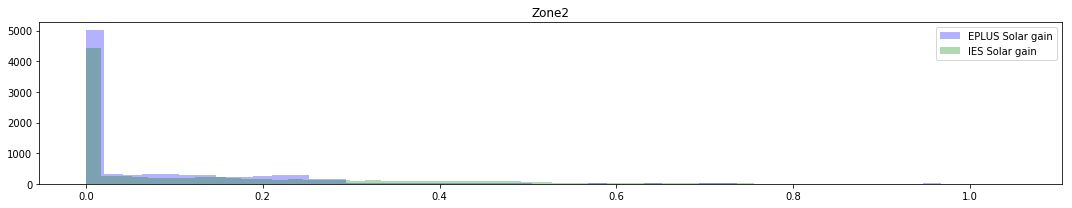

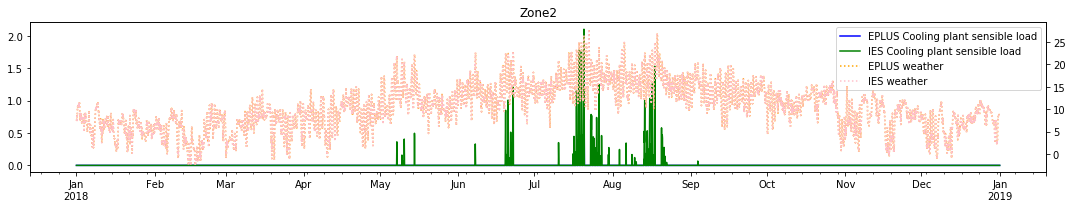

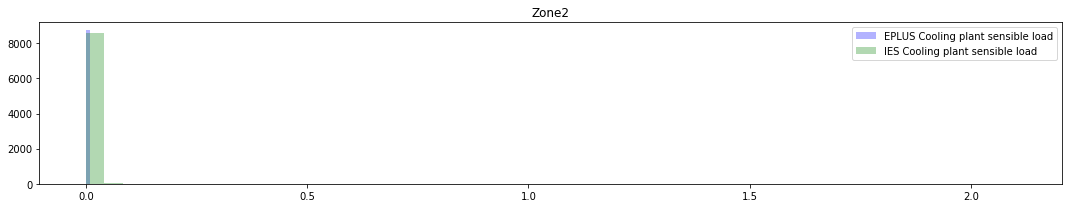

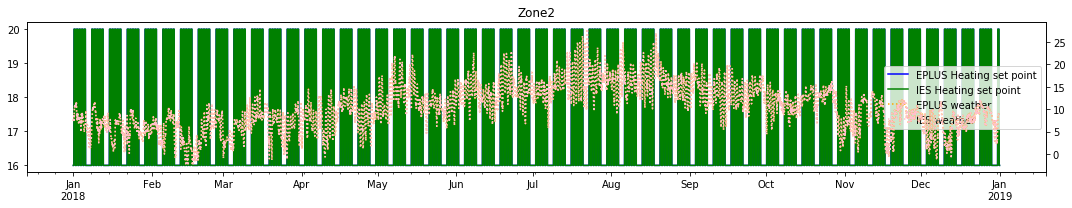

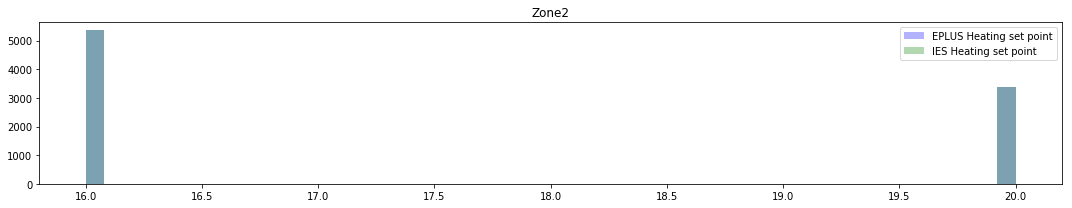

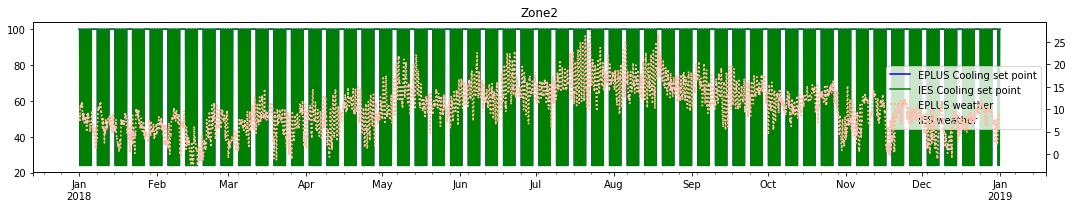

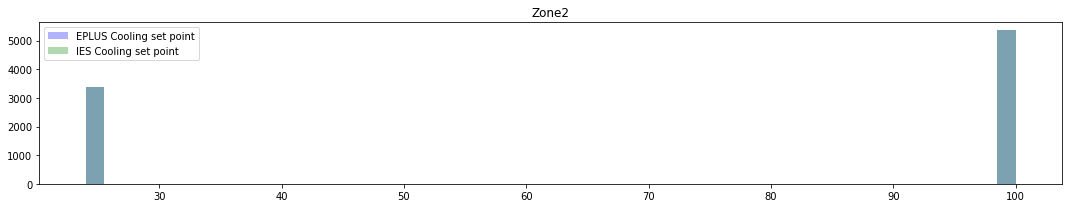

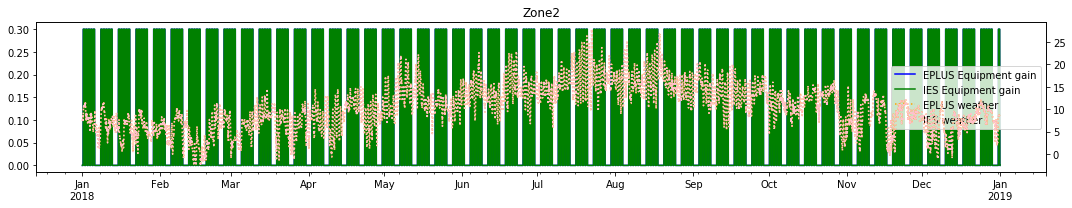

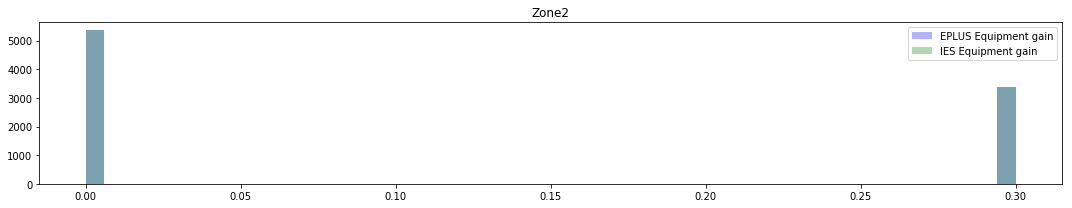

In [400]:
###########################################
# PRINT A PLOT SHOWING SPECIFIC VARIABLES #
###########################################

space = "Zone2"
variable = link_vars.values()[1]
start = "2018-01-01"
end = "2018-12-31"

for variable in link_vars.values():

    # Time-series plot
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 3))
    ax2 = ax1.twinx()
    EPLUS_WEATHER["dry_bulb_temperature"][start:end].plot(ax=ax2, c="orange", ls=":", label="EPLUS weather")
    IES_WEATHER["dry_bulb_temperature"][start:end].plot(ax=ax2, c="pink", ls=":", label="IES weather")
    EPLUS[space][variable][start:end].plot(ax=ax1, c="BLUE", label="EPLUS {0:}".format(variable))
    IES[space][variable][start:end].plot(ax=ax1, c="GREEN", label="IES {0:}".format(variable))
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc=0)
    plt.title(space)
    plt.tight_layout()

    # Histogram plot (for whole year)
    bins = 50
    fig, ax = plt.subplots(1, 1, figsize=(15, 3))
    ax.hist(EPLUS[space][variable], bins, alpha=0.3, label="EPLUS {0:}".format(variable), color="BLUE")
    ax.hist(IES[space][variable], bins, alpha=0.3, label="IES {0:}".format(variable), color="GREEN")
    ax.legend()
    plt.title(space)
    plt.tight_layout()

In [ ]:
# TODO - Fix the heating plant sensible load issue!

In [96]:
test_vals = np.concatenate([np.linspace(0.001, 1.0, 70), np.linspace(1.0, 5.0, 50)])

test_vals

array([1.00000000e-03, 1.54782609e-02, 2.99565217e-02, 4.44347826e-02,
       5.89130435e-02, 7.33913043e-02, 8.78695652e-02, 1.02347826e-01,
       1.16826087e-01, 1.31304348e-01, 1.45782609e-01, 1.60260870e-01,
       1.74739130e-01, 1.89217391e-01, 2.03695652e-01, 2.18173913e-01,
       2.32652174e-01, 2.47130435e-01, 2.61608696e-01, 2.76086957e-01,
       2.90565217e-01, 3.05043478e-01, 3.19521739e-01, 3.34000000e-01,
       3.48478261e-01, 3.62956522e-01, 3.77434783e-01, 3.91913043e-01,
       4.06391304e-01, 4.20869565e-01, 4.35347826e-01, 4.49826087e-01,
       4.64304348e-01, 4.78782609e-01, 4.93260870e-01, 5.07739130e-01,
       5.22217391e-01, 5.36695652e-01, 5.51173913e-01, 5.65652174e-01,
       5.80130435e-01, 5.94608696e-01, 6.09086957e-01, 6.23565217e-01,
       6.38043478e-01, 6.52521739e-01, 6.67000000e-01, 6.81478261e-01,
       6.95956522e-01, 7.10434783e-01, 7.24913043e-01, 7.39391304e-01,
       7.53869565e-01, 7.68347826e-01, 7.82826087e-01, 7.97304348e-01,
      

In [148]:
idf.idfobjects["MATERIAL"][8]


MATERIAL,
    EXTERIOR FLOOR MIDDLE MATERIAL,    !- Name
    MediumRough,              !- Roughness
    0.2,                      !- Thickness
    0.036,                    !- Conductivity
    50,                       !- Density
    1030,                     !- Specific Heat
    0.1,                      !- Thermal Absorptance
    0.7,                      !- Solar Absorptance
    1.0;                      !- Visible Absorptance


In [149]:
# Modify a single variable and get the vbalues from which to interpolate custom insulation thickness for U-Values

from eppy.modeleditor import IDF

u_val_dict = {}
for insulation_thickness in test_vals:
    
    idf_file = "Test_4Zone_modified.idf"
    IDF.setiddname("C:/EnergyPlusV8-8-0/Energy+.idd")
#     IDF.setiddname("/Applications/EnergyPlus-8-8-0/Energy+.idd")
    idf = IDF(idf_file)
    idf.idfobjects["MATERIAL"][8].Thickness = insulation_thickness
    idf.saveas(idf_file)
    
    print("Running for an insulation thickness of {0:}".format(insulation_thickness))

    for _file in ["eplusmtr.csv", "eplusout.audit", "eplusout.bnd", "eplusout.csv", "eplusout.eio", "eplusout.end", "eplusout.err", "eplusout.eso", "eplusout.expidf", "eplusout.mdd", "eplusout.mtd", "eplusout.rdd", "eplusout.rvaudit", "eplusout.shd", "eplusout.sql", "sqlite.err", "test.log",]:
        try:
            os.remove(_file)
        except:
            pass

    print("Running simulation ...")
    
    weatherfile = "C:/Users/tgerrish/Desktop/SAMAzure/TestFiles/Resources/GBR_Cardiff_CIBSE_TRY_ORIGINAL.epw"
    subprocess.call("C:/EnergyPlusV8-8-0/energyplus.exe -a -x -r -w {0:} C:/Users/tgerrish/Desktop/SAMAzure/TestFiles/reference/outputComparison/Test_4Zone_modified.idf".format(weatherfile), shell=True)

#     weatherfile = "/Users/Tristan/Desktop/SAMAzure/TestFiles/Resources/GBR_Cardiff_CIBSE_TRY_ORIGINAL.epw"
#     subprocess.call("/Applications/EnergyPlus-8-8-0/energyplus-8.8.0 -a -x -r -w /Users/Tristan/Desktop/SAMAzure/TestFiles/Resources/GBR_Cardiff_CIBSE_TRY_ORIGINAL.epw /Users/Tristan/Desktop/SAMAzure/TestFiles/reference/outputComparison/Test_4Zone_modified.idf", shell=True)
    
    print("Simulation complete\n")
    
    u_val_dict[float(get_eplus_construction_properties("eplustbl.csv")["U-Value W/m2K"]["EXTERIOR FLOOR"])] = insulation_thickness


Running for an insulation thickness of 0.001
Running simulation ...
Simulation complete

Running for an insulation thickness of 0.0154782608696
Running simulation ...
Simulation complete

Running for an insulation thickness of 0.0299565217391
Running simulation ...
Simulation complete

Running for an insulation thickness of 0.0444347826087
Running simulation ...
Simulation complete

Running for an insulation thickness of 0.0589130434783
Running simulation ...
Simulation complete

Running for an insulation thickness of 0.0733913043478
Running simulation ...
Simulation complete

Running for an insulation thickness of 0.0878695652174
Running simulation ...
Simulation complete

Running for an insulation thickness of 0.102347826087
Running simulation ...
Simulation complete

Running for an insulation thickness of 0.116826086957
Running simulation ...
Simulation complete

Running for an insulation thickness of 0.131304347826
Running simulation ...
Simulation complete

Running for an insulati

Simulation complete

Running for an insulation thickness of 2.22448979592
Running simulation ...
Simulation complete

Running for an insulation thickness of 2.30612244898
Running simulation ...
Simulation complete

Running for an insulation thickness of 2.38775510204
Running simulation ...
Simulation complete

Running for an insulation thickness of 2.4693877551
Running simulation ...
Simulation complete

Running for an insulation thickness of 2.55102040816
Running simulation ...
Simulation complete

Running for an insulation thickness of 2.63265306122
Running simulation ...
Simulation complete

Running for an insulation thickness of 2.71428571429
Running simulation ...
Simulation complete

Running for an insulation thickness of 2.79591836735
Running simulation ...
Simulation complete

Running for an insulation thickness of 2.87755102041
Running simulation ...
Simulation complete

Running for an insulation thickness of 2.95918367347
Running simulation ...
Simulation complete

Running fo

In [150]:
u_val_dict

{0.01982: 5.0,
 0.02075: 1.7346938775510203,
 0.02178: 1.6530612244897958,
 0.02291: 1.5714285714285714,
 0.02416: 1.489795918367347,
 0.02556: 1.4081632653061225,
 0.02714: 1.3265306122448979,
 0.02891: 1.2448979591836735,
 0.03094: 1.163265306122449,
 0.03328: 1.0816326530612246,
 0.03599: 1.0,
 0.03652: 0.9855217391304348,
 0.03707: 0.9710434782608696,
 0.03763: 0.9565652173913044,
 0.03821: 0.9420869565217392,
 0.0388: 0.927608695652174,
 0.03942: 0.9131304347826087,
 0.04005: 0.8986521739130435,
 0.04071: 0.8841739130434784,
 0.04139: 0.8696956521739131,
 0.04209: 0.8552173913043478,
 0.04281: 0.8407391304347827,
 0.04356: 0.8262608695652175,
 0.04434: 0.8117826086956522,
 0.04514: 0.797304347826087,
 0.04598: 0.7828260869565218,
 0.04685: 0.7683478260869566,
 0.04774: 0.7538695652173913,
 0.04868: 0.7393913043478261,
 0.04965: 0.7249130434782609,
 0.05066: 0.7104347826086957,
 0.05172: 0.6959565217391305,
 0.05282: 0.6814782608695652,
 0.05396: 0.667,
 0.05516: 0.6525217391304349

In [153]:
u_values = u_val_dict.keys()
insulation_thicknesses = u_val_dict.values()
insulation_thicknesses, u_values = zip(*sorted(list(zip(*[u_values, insulation_thicknesses])), key=lambda x: x[0]))

print("u_values = [{0:}]\n".format(", ".join([str(i) for i in u_values])))

print("insulation_thicknesses = [{0:}]\n".format(", ".join([str(i) for i in insulation_thicknesses])))

print("Min: {0:}\nMax: {1:}".format(min(u_values), max(u_values)))

u_values = [5.0, 1.7346938775510203, 1.6530612244897958, 1.5714285714285714, 1.489795918367347, 1.4081632653061225, 1.3265306122448979, 1.2448979591836735, 1.163265306122449, 1.0816326530612246, 1.0, 0.9855217391304348, 0.9710434782608696, 0.9565652173913044, 0.9420869565217392, 0.927608695652174, 0.9131304347826087, 0.8986521739130435, 0.8841739130434784, 0.8696956521739131, 0.8552173913043478, 0.8407391304347827, 0.8262608695652175, 0.8117826086956522, 0.797304347826087, 0.7828260869565218, 0.7683478260869566, 0.7538695652173913, 0.7393913043478261, 0.7249130434782609, 0.7104347826086957, 0.6959565217391305, 0.6814782608695652, 0.667, 0.6525217391304349, 0.6380434782608696, 0.6235652173913043, 0.6090869565217392, 0.594608695652174, 0.5801304347826087, 0.5656521739130435, 0.5511739130434783, 0.5366956521739131, 0.5222173913043479, 0.5077391304347826, 0.4932608695652174, 0.4787826086956522, 0.464304347826087, 0.44982608695652176, 0.43534782608695655, 0.42086956521739133, 0.406391304347

Text(0.5,1,'Target U Value: 1.200\nRequired Insulation thickness: 0.030')

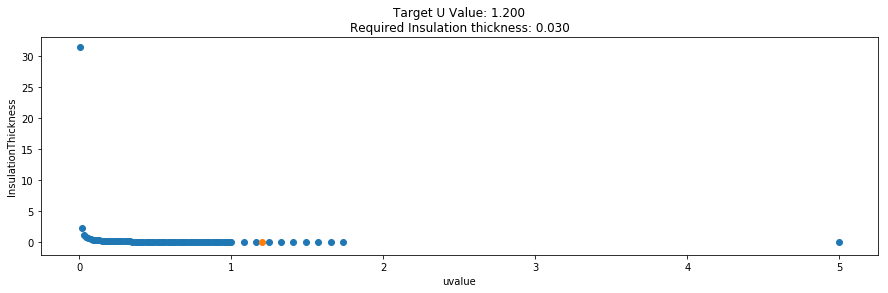

In [152]:
from scipy import interpolate

f = interpolate.interp1d(u_values, insulation_thicknesses)

fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.scatter(u_values, insulation_thicknesses)

target_u_value = 1.2
ax.scatter(target_u_value, f(target_u_value))
ax.set_ylabel("InsulationThickness")
ax.set_xlabel("uvalue")
ax.set_title("Target U Value: {0:0.3f}\nRequired Insulation thickness: {1:0.3f}".format(target_u_value, f(target_u_value)))

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from scipy.stats import ttest_ind, pearsonr, spearmanr

WEATHER_FILE = r"C:\Users\tgerrish\Desktop\temp_delete\ExtWeather.csv"
EPLUS_OUTPUT = r"C:\Users\tgerrish\Desktop\temp_delete\eplusout.csv"
IES_OUTPUT = r"C:\Users\tgerrish\Desktop\temp_delete\Test_4ZoneIES\vista\File Name [IESCheck.aps].csv"

# Load weather
WEATHER = pd.read_csv(WEATHER_FILE, index_col=0, header=0, parse_dates=True)
WEATHER = WEATHER.resample("60T").mean()

# LOAD IES RESULTS FILE
IES = pd.read_csv(IES_OUTPUT, index_col=[0, 1, 2, 3], header=[0, 1, 2]).transpose().iloc[:-1, :]

# TIDY IES RESULTS FILE
IES.index = pd.DatetimeIndex(start="2018-01-01 00:30", end="2018-12-31 23:30", freq="60T")
IES.columns = pd.MultiIndex.from_tuples(list(zip(*[IES.columns.get_level_values(3), IES.columns.get_level_values(0)])), names=["zone", "variable"])
IES.sort_index(axis=1, ascending=True, inplace=True)
IES = IES.apply(pd.to_numeric, errors="coerce")
IES = IES.resample("60T").mean()

# Load the CSV file for the EnergyPlus output
EPLUS = pd.read_csv(EPLUS_OUTPUT, index_col=0, header=0, low_memory=False)
EPLUS.index = pd.DatetimeIndex(start="2018-01-01 01:00", end="2019-01-01 00:00", freq="60T")

# Get masks to descibe whether each column needs to be converted to IES units
J_to_kW = [True if "[J]" in col else False for col in EPLUS.columns]
m3s_to_ls = [True if "[m3/s]" in col else False for col in EPLUS.columns]
m3_to_l = [True if "[m3]" in col else False for col in EPLUS.columns]

# Convert the columns
varr = []
zone = []
new_cols = []
for i, j in enumerate(EPLUS.columns):
    if J_to_kW[i]:
        EPLUS.iloc[0:, i] = EPLUS.iloc[0:, i] / 3600000
    else:
        pass
    if m3s_to_ls[i] or m3_to_l[i]:
        EPLUS.iloc[0:, i] = EPLUS.iloc[0:, i] * 1000
    else:
        pass
    new_cols.append(j.replace("[J]", "[kW]").replace("[m3/s]", "[l/s]").replace("[m3]", "[l]").replace("(Hourly)", ""))
    if "ZONE1" in j:
        zone.append("Zone1")
    elif "ZONE2" in j:
        zone.append("Zone2")
    elif "ZONE3" in j:
        zone.append("Zone3")
    elif "ZONE4" in j:
        zone.append("Zone4")
    varr.append(j.split(":")[1].split(" [")[0])

# Replace values in column names to save on confusion
EPLUS.columns = new_cols

EPLUS.columns = pd.MultiIndex.from_tuples(list(zip(*[zone, varr])), names=["zone", "variable"])

# Sort the columns
EPLUS.sort_index(axis=1, ascending=True, inplace=True)

# Resample to common timesetp
EPLUS = EPLUS.resample("60T").mean()

C:\Users\tgerrish\AppData\Local\Continuum\anaconda3\envs\py27\lib\site-packages\IPython\core\interactiveshell.py:2718: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,

In [50]:
# Compare tabularly
space = "Zone1"

col1 = ["EPLUS", "IES"]
col2 = link_vars.values()
idx = ["Min", "Max", "Median", "Mean", "StDev"]

cols = pd.MultiIndex.from_product([col1, col2], names=('engine', 'var'))

a = []
for n, i in enumerate([EPLUS, IES]):
    for j, k in zip(*[link_vars.values(), link_vars.keys()]):
        if n == 0:
            a.append([i[space][k].min(), i[space][k].max(), i[space][k].median(), i[space][k].mean(), np.std(i[space][k])])
        else:
            a.append([i[space][j].min(), i[space][j].max(), i[space][j].median(), i[space][j].mean(), np.std(i[space][j])])

df = pd.DataFrame(index=idx, columns=cols, data=list(zip(*a)))
df
#df.filter(regex="Solar")

engine           EPLUS                                                   \
var    Air temperature Number of people Internal gain Cooling set point   
Min          16.000000         0.000000      0.000000         24.000000   
Max          28.480223        50.000000      5.550000        100.000000   
Median       20.000000         0.000000      0.000000        100.000000   
Mean         19.223746        13.035103      1.656948         70.563014   
StDev         2.128357        19.834030      2.245738         37.022625   

engine                                                    \
var    Natural vent People gain Lighting gain Solar gain   
Min        0.000000    0.000000      0.000000   0.000000   
Max      791.915384    3.750000      0.600000   1.990845   
Median     0.000000    0.000000      0.000000   0.000904   
Mean     269.947516    0.977633      0.214521   0.375509   
StDev    361.909631    1.487552      0.287564   0.545448   

engine                                                       \
var    Mean radiant temperature Cooling plant sensible load   
Min                   14.557846                    0.000000   
Max                   28.048128                    2.071844   
Median                19.673307                    0.000000   
Mean                  19.616798                    0.000963   
StDev                  2.439551                    0.034340   

engine             ...                     IES                           \
var                ...             People gain Lighting gain Solar gain   
Min                ...                0.000000      0.000000   0.000000   
Max                ...                0.937500      0.150000   1.816827   
Median             ...                0.000000      0.000000   0.018974   
Mean               ...                0.244408      0.053630   0.217398   
StDev              ...                0.371888      0.071891   0.342412   

engine                                                                         \
var    Mean radiant temperature Cooling plant sensible load Relative humidity   
Min                   15.445867                    0.000000         18.547850   
Max                   28.679016                    2.172751         81.056931   
Median                20.048777                    0.000000         50.532028   
Mean                  19.936217                    0.016631         50.359008   
StDev                  2.911043                    0.127319         11.300112   

engine                                                         \
var    Dew-point temperature Equipment gain Heating set point   
Min                -4.122734       0.000000         16.000000   
Max                20.546637       0.300000         20.000002   
Median              8.672545       0.000000         16.000000   
Mean                8.352494       0.116199         17.549316   
StDev               4.439177       0.146142          1.948560   

engine                              
var    Heating plant sensible load  
Min                       0.000000  
Max                       5.824881  
Median                    0.000000  
Mean                      0.454555  
StDev                     0.877890  

[5 rows x 30 columns]

In [53]:
EPLUS[space]["Zone Windows Total Transmitted Solar Radiation Energy"].sum(), IES[space]["Solar gain"].sum()

(3289.4569812533596, 1904.4075559999999)

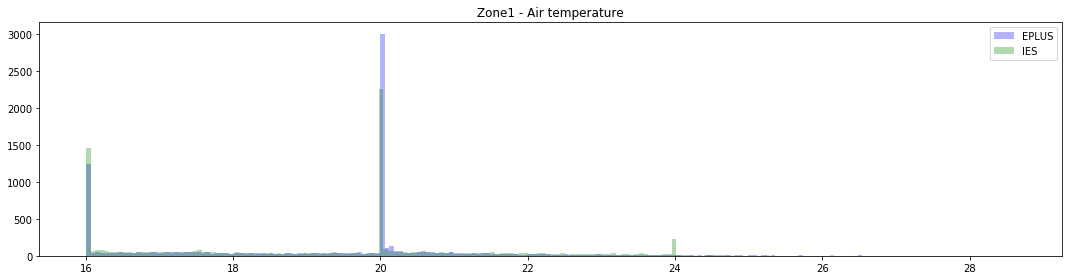

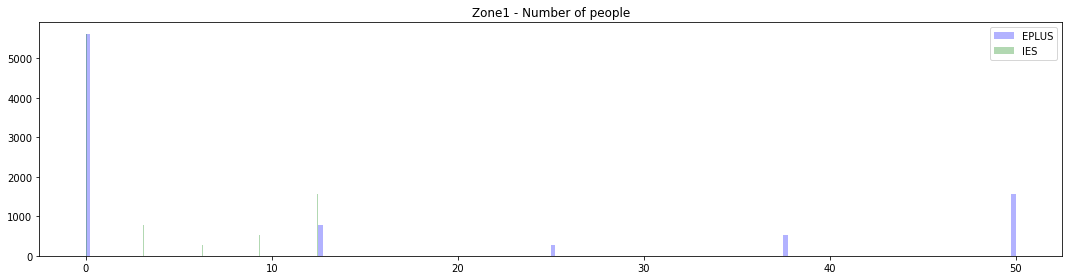

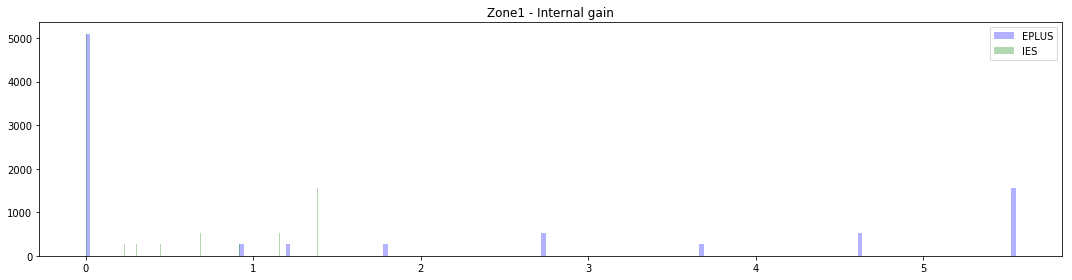

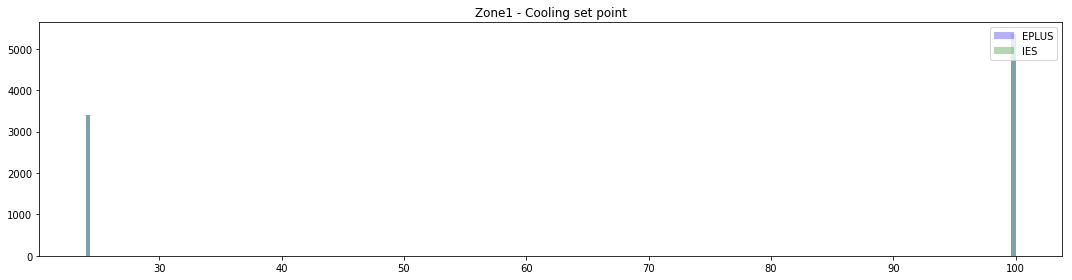

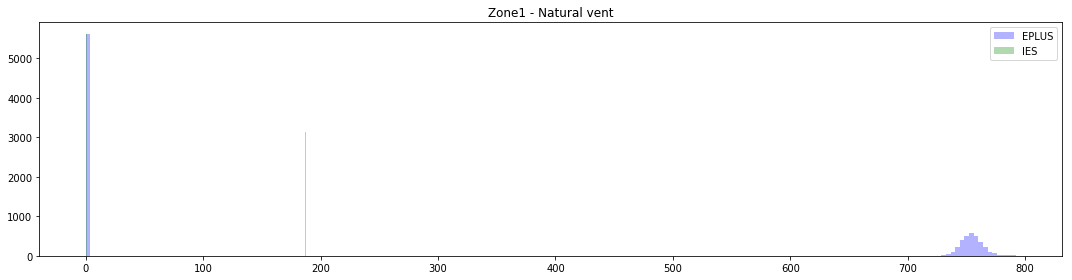

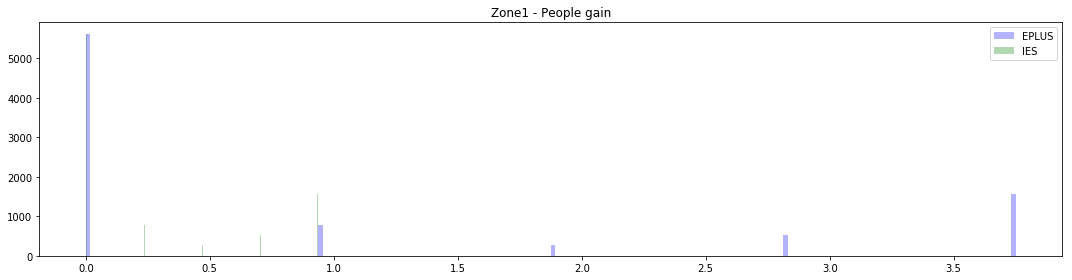

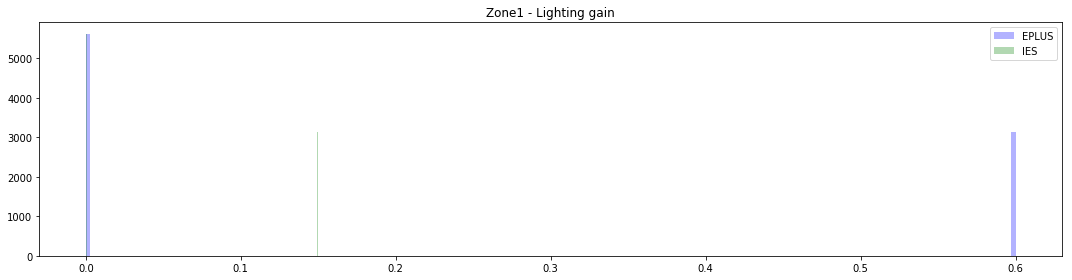

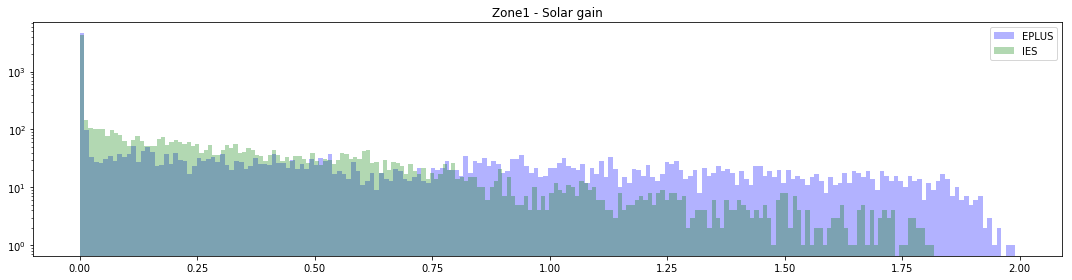

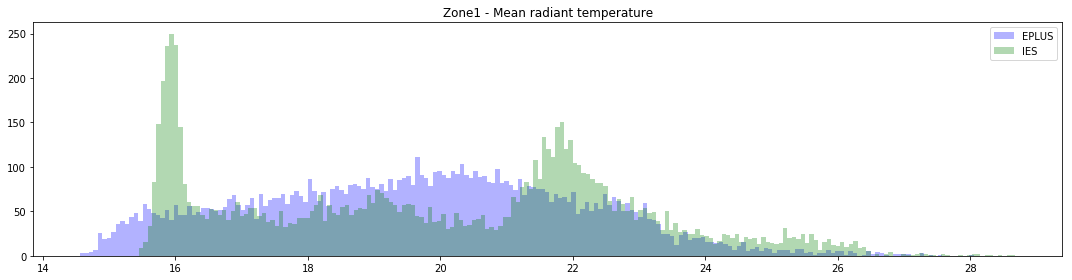

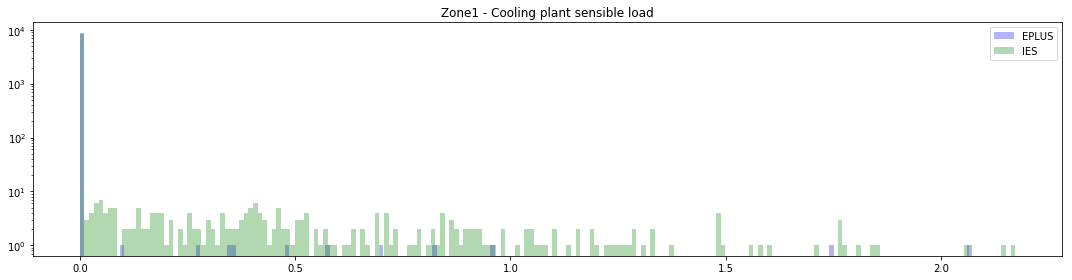

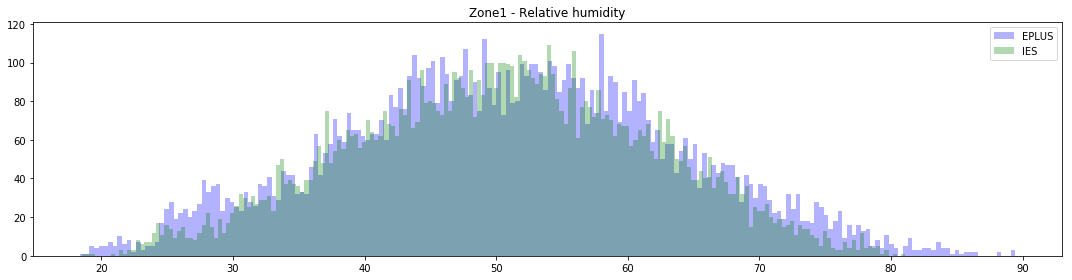

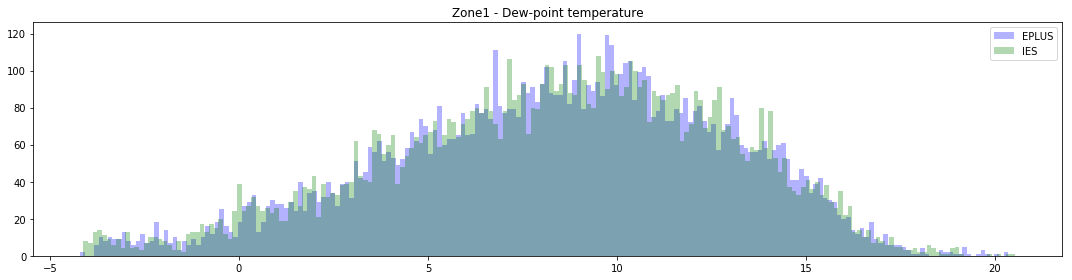

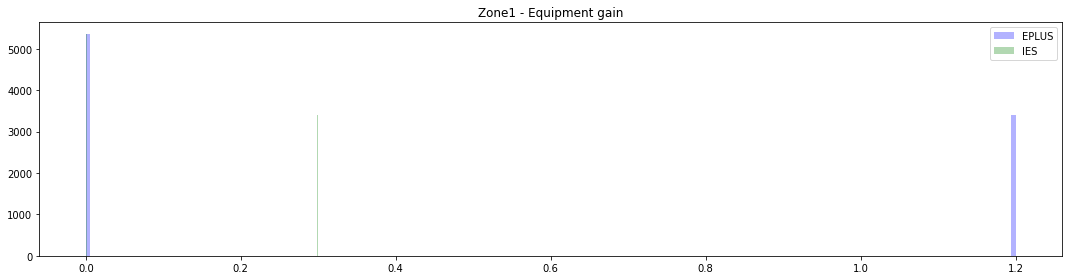

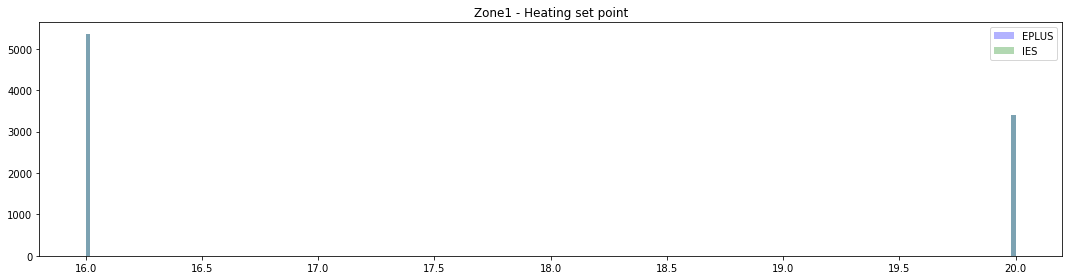

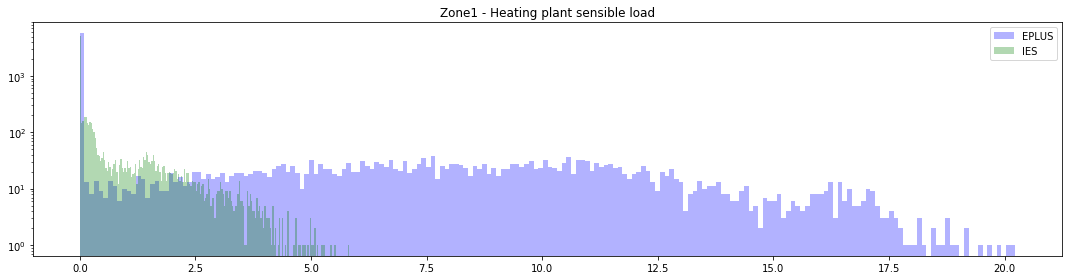

In [51]:
# Compare graphically
space = "Zone1"
bins = 200

for i, j in zip(*[link_vars.values(), link_vars.keys()]):
    fig, ax = plt.subplots(1, 1, figsize=(15, 4))
    ax.hist(EPLUS[space][j], bins, alpha=0.3, label='EPLUS', color="BLUE")
    ax.hist(IES[space][i], bins, alpha=0.3, label='IES', color="GREEN")
    plt.legend(loc='upper right')
    plt.title("{0:} - {1:}".format(space, i))
    
    if "Heating plant sensible" in i or "Cooling plant sensible" in i or "Solar gain" in i:
        plt.yscale('log', nonposy='clip')
    else:
        plt.yscale('linear')
    
    plt.tight_layout()

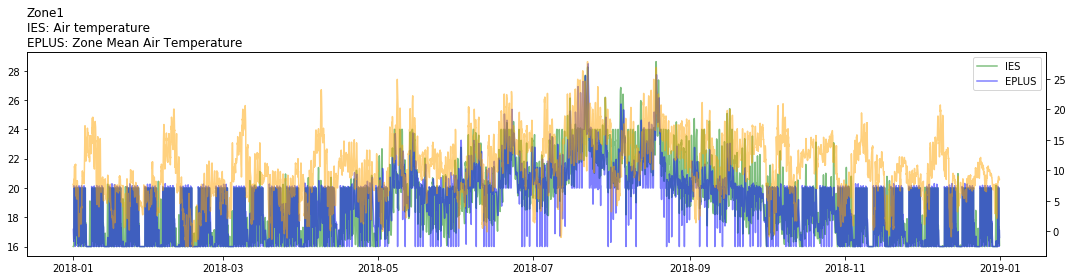

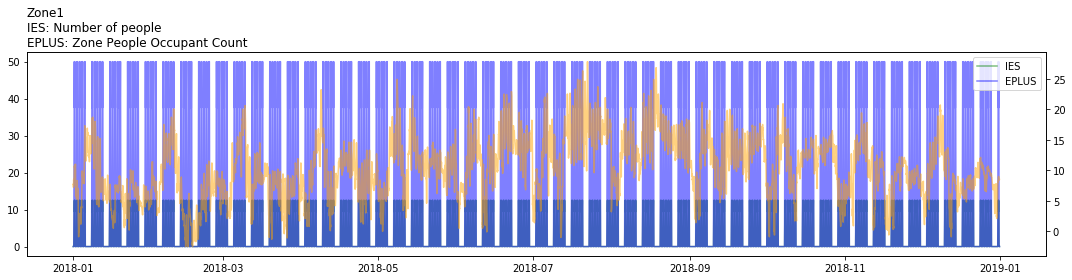

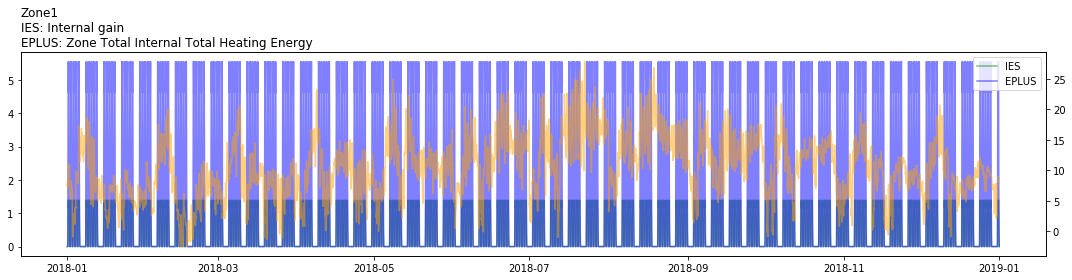

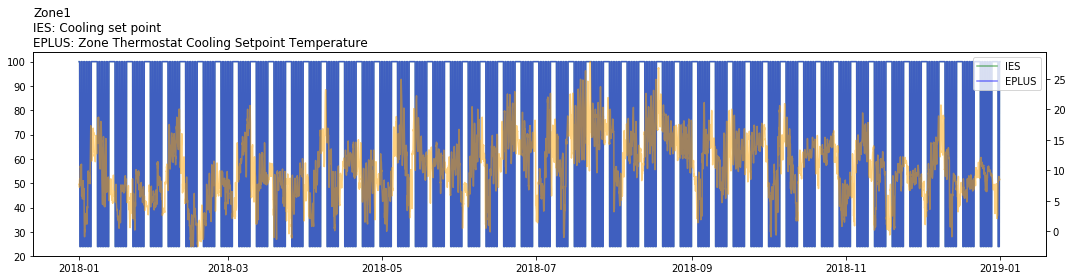

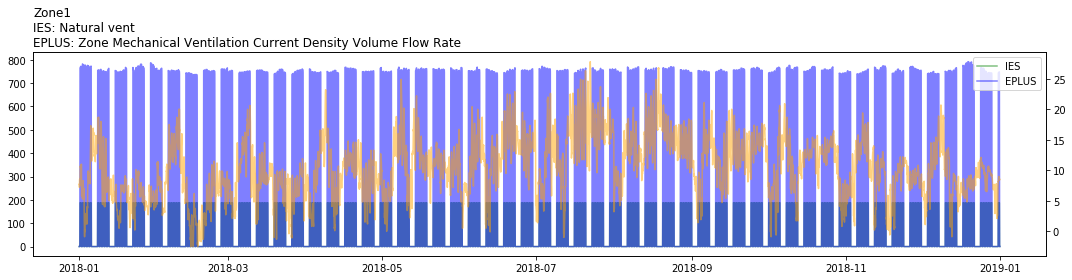

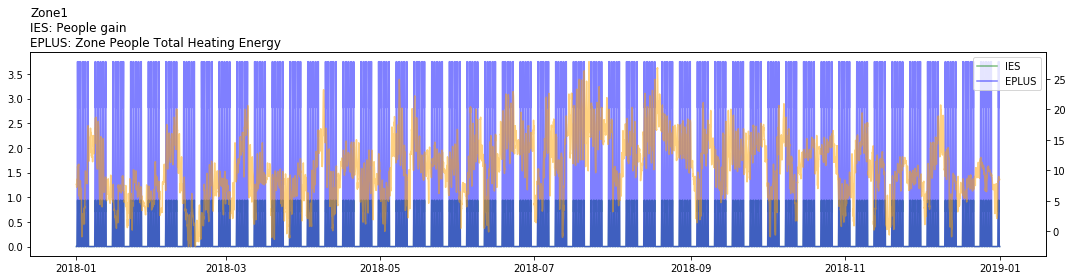

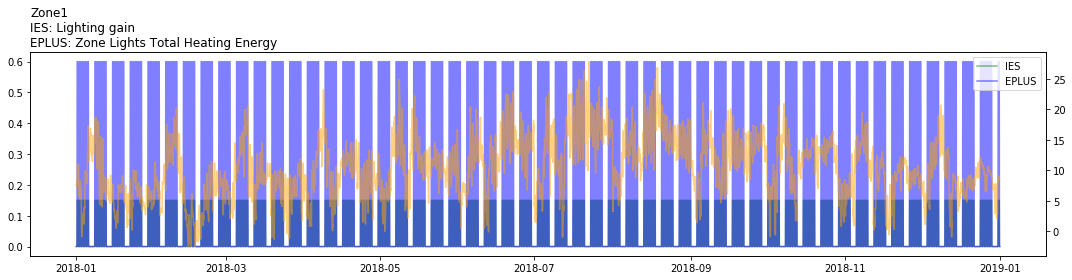

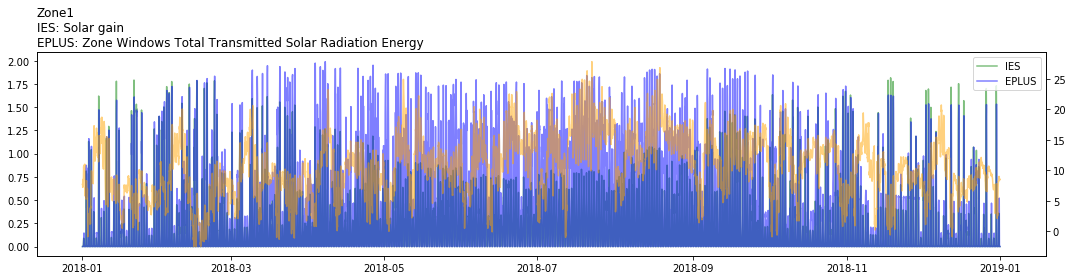

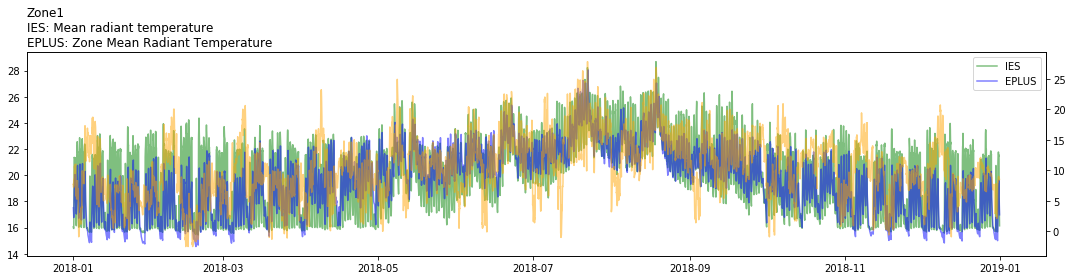

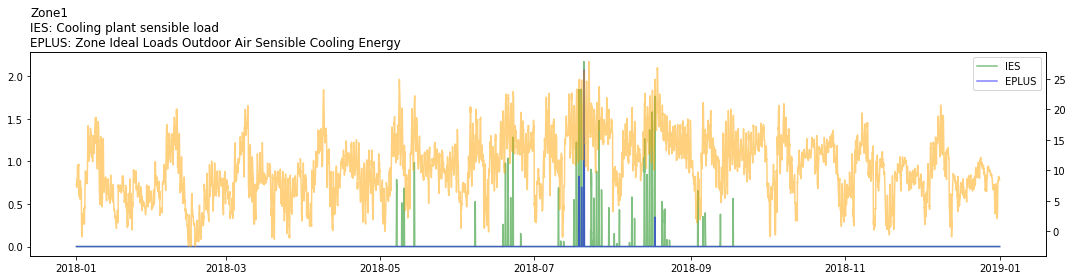

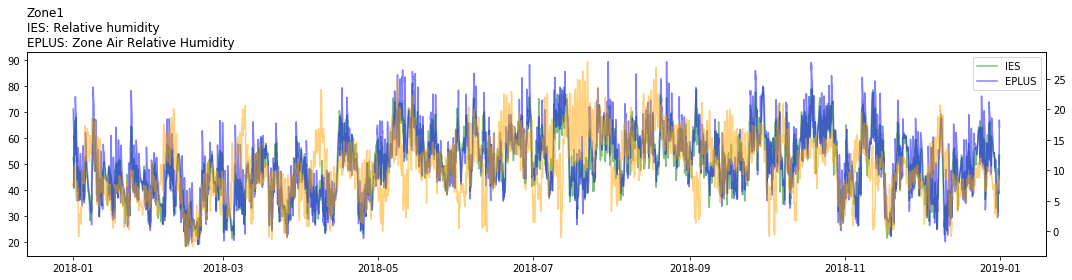

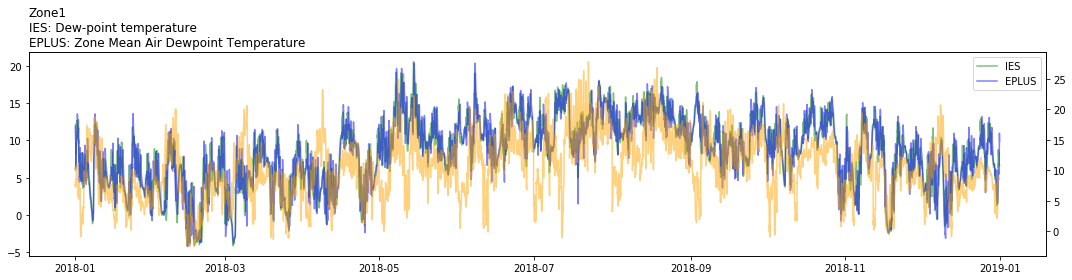

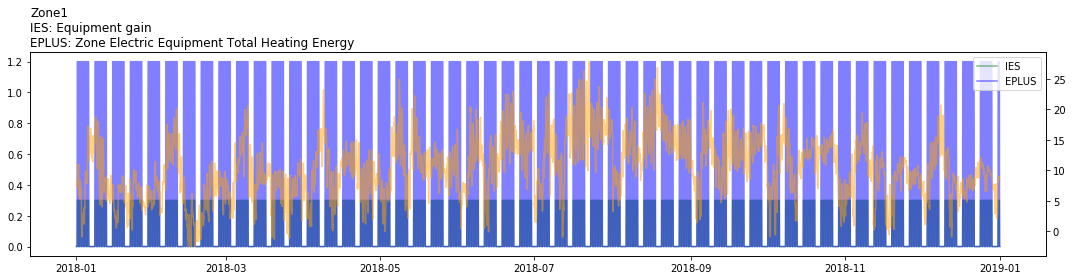

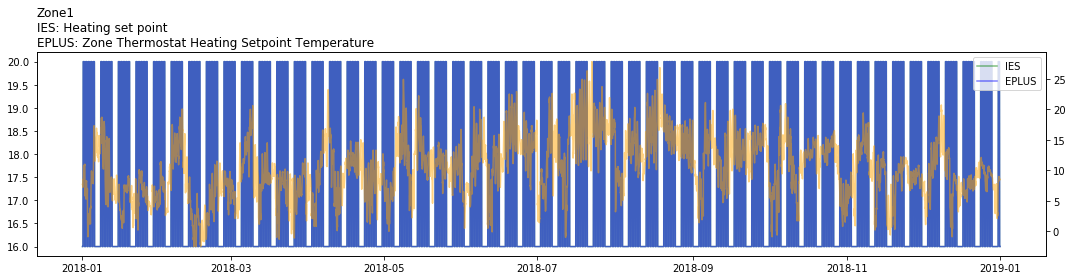

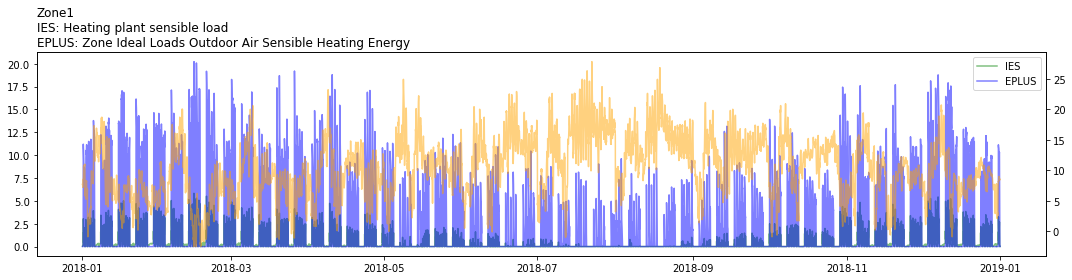

In [52]:
space = "Zone1"
var_num = 2
start = "2018-01-01"
end = "2018-12-31"

for var_num in range(len(link_vars.keys())):
    eplus_var = link_vars.keys()[var_num]
    ies_var = link_vars.values()[var_num]

    fig, ax = plt.subplots(1, 1, figsize=(15, 4))
    axy = ax.twinx()
    ax.plot(IES[space][ies_var][start:end], label="IES", color="GREEN", alpha=0.5)
    ax.plot(EPLUS[space][eplus_var][start:end], label="EPLUS", color="BLUE", alpha=0.5)
    axy.plot(WEATHER["DryBulbTemperature_C"][start:end], label="Te", color='ORANGE', alpha=0.5, ls="-")
    ax.legend(loc='upper right')
    plt.title("{2:}\nIES: {0:}\nEPLUS: {1:}".format(link_vars.values()[var_num], link_vars.keys()[var_num], space), ha="left", x=0.0)
    plt.tight_layout()

In [152]:
# Import data from TAS output

TAS = pd.read_csv(r"C:\Users\tgerrish\Desktop\temp_delete\ExportData1.csv").iloc[:, 4:8]
TAS.columns = pd.MultiIndex.from_product([[i.split(" ")[0] for i in TAS.columns], ["Solar gain"]], names=('zone', 'variable'))
TAS.index = pd.DatetimeIndex(start="2018-01-01 01:00", end="2019-01-01 00:00", freq="60T")
TAS = TAS / 1000

In [154]:
print(IES["Zone1"]["Solar gain"].sum())
print(TAS["Zone1"]["Solar gain"].sum())

1904.407558
2023.69656844


In [169]:
pd.concat([IES["Zone2"]["Solar gain"], TAS["Zone2"]["Solar gain"]], axis=1).describe()

Solar gain   Solar gain
count  8760.000000  8760.000000
mean      0.181805     0.192150
std       0.291395     0.308808
min       0.000000     0.000000
25%       0.000000     0.000000
50%       0.021327     0.009156
75%       0.275469     0.292155
max       1.830422     1.767900

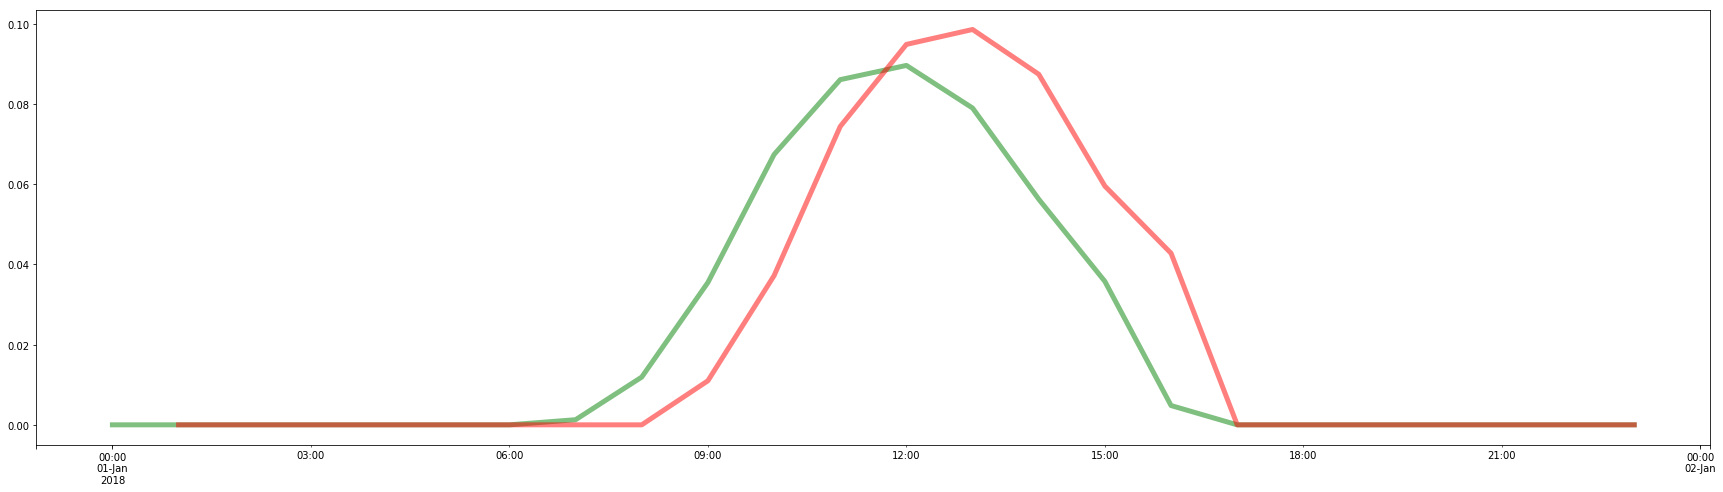

In [161]:
fig, ax = plt.subplots(1, 1, figsize=(30, 8))

IES["Zone2"]["Solar gain"]["2018-01-01"].plot(ax=ax, label="IES", color="GREEN", alpha=0.5, lw=5)
TAS["Zone2"]["Solar gain"]["2018-01-01"].plot(ax=ax, label="TAS", color="RED", alpha=0.5, lw=5)